As an extension of the single-item newsvendor problem, we study the multi-item problem where multiple items have their own uncertain demand. Let $d^{(j)}_{i}$ be the $i$-th realization of the $j$-th item's demand, where $i=1,2,3$. 
We assume that the demand takes on the same possible values for all items, i.e., $d^{(j)}_{i}\in \{4,8,10\}$ for all $j$. 
We take $j=1,2,3$ and consider the sum of the individual profit functions
\begin{align}
    r_{\mathrm{tot}}(\mathbf{d},\mathbf{y})=r_1(d^{(1)},y_1)+r_2(d^{(2)},y_2)+r_3(d^{(3)},y_3),
\end{align}
where
\begin{align}
     r_j(d^{(j)},y_j)&=v_j\min\{d^{(j)},y_j\}+s_j(y_j-d^{(j)})_+-l_j(d^{(j)}-y_j)_+-c_jy_j,
\end{align}
with $v_j,s_j,l_j,c_j$ the parameters corresponding to item $j$. Since each realization of $d^{(j)}$ contributes to a possible realization of $r_{\mathrm{tot}}(\mathbf{d},\mathbf{y})$, there are in total $N=3^3=27$ possible realizations. The worst-case risk evaluation minimization problem with Kullback-Leibler divergence and the CVaR distortion risk measure is formulated as
\begin{align}
\begin{split}
    \min_{0\leq y\leq 10, t\in \mathbb{R}}\left\{t~ \middle |~
        \sup_{(\mathbf{q},\mathbf{\bar{q}})\in \mathcal{U}_{\phi_{kl},h_{cv}}(\mathbf{p})}-\sum^{27}_{k=1}\bar{q}_kr_{\mathrm{tot},k}(\mathbf{y},\mathbf{d})\leq t\right\}.
\end{split}
\end{align}
Here, $\mathbf{p}\in \mathbb{R}^{27}$ and is determined by considering the probability of each combination of realizations of $(d^{(1)},d^{(2)},d^{(3)})$, which is the product of the probabilities $\mathbf{p}^{(1)},\mathbf{p}^{(2)},\mathbf{p}^{(3)}$ of each individual realization. 
The parameters we used are given in the following table.


| $\mathrm{Item}(j)$ | 1    | 2   | 3   |
|--------------------|------|-----|-----|
| $c$                | 4    | 5   | 4   |
| $v$                | 6    | 8   | 5   |
| $s$                | 2    | 2.5 | 1.5 |
| $l$                | 4    | 3   | 4   |


Furthermore, the demand of each item $j$ has state probabilities 
\begin{align*}
\mathbf{p}^{(1)}=(0.375,0.375,0.25),~\mathbf{p}^{(2)}=(0.25, 0.25,0.5),~\mathbf{p}^{(3)}=(0.127,0.786,0.087).
\end{align*}
The nominal problem is the following problem with respect to only the nominal probability vector $\mathbf{p}$
\begin{align}
\begin{split}
    \min_{0\leq y\leq 10, t\in \mathbb{R}}\left\{t~\middle |~
        \sup_{\mathbf{\bar{q}}\in M_{h_{cv}}(\mathbf{p})}-\sum^{27}_{k=1}\bar{q}_kr_{\mathrm{tot},k}(\mathbf{y},\mathbf{d})\leq t\right\}.
\end{split}
\end{align}

In [2]:
import numpy as np
import pandas as pd
import cvxpy as cp
import mosek
import matplotlib.pyplot as plt
import scipy.stats
from scipy.stats import rankdata
import distortion_function as hf
import phi_divergence as phi
import Hit_and_Run as hr
import itertools as itertools

The following code solves both the robust and the nominal problem.

In [5]:
def r_obj(d,y,par_news):
    [v_news, l_news, s_news, c_news] = par_news
    return((s_news-v_news)*cp.pos(y-d)-l_news*cp.pos(d-y)+(v_news-c_news)*y)

def mnews_affine_riskmin(p,d,r,indices,par_mnews,phi_conj,slope,const):
    N = len(p)
    I = len(par_mnews)
    K = len(slope)
    lbda = cp.Variable((N,K), nonneg = True)
    y = cp.Variable(I, nonneg = True)
    v = cp.Variable(K, nonneg = True)
    alpha = cp.Variable(1)
    beta = cp.Variable(1)
    gamma = cp.Variable(1,nonneg = True)
    t = cp.Variable(N)
    s = cp.Variable(N)
    c = cp.Variable(1)
    w = cp.Variable(N)
    constraints = [y<= np.max(d)]
    for i in range(N):
        r_profit = 0
        for j in range(I):
            r_profit = r_profit + r_obj(d[indices[i][j]],y[j],par_mnews[j])
        if i == 0:
            profit = r_profit
        else:
            profit = cp.hstack((profit, r_profit))
    for i in range(N):
        constraints.append(-profit[i] - cp.sum(lbda[i]) - beta <= 0)
        constraints.append(s[i] == -alpha + lbda[i]@slope)
        constraints.append(lbda[i] <= v)
        constraints = phi_conj(gamma,s[i],t[i],w[i],constraints)
    constraints.append(alpha + beta + gamma * r  + v@const + p@t <= c)
    obj = cp.Minimize(c)
    prob = cp.Problem(obj,constraints)
    prob.solve(solver=cp.MOSEK)
    return(y.value, c.value)

In [6]:
def r_obj_calc(d,y,par_news):
    [v_news, l_news, s_news, c_news] = par_news
    return((s_news-v_news)*np.maximum(y-d,0)-l_news*np.maximum(d-y,0)+(v_news-c_news)*y)

### some technical function that converges a list to a set with certain properties
def ranktoset (A):    
    A = list(A)
    sets = [[A[0]]]
    for i in range(1,len(A)):
        new = A[0:i+1]
        sets.append(new)
    return(sets)

### This function calculates the worst-case risk evaluation given a solution.

def robustcheck_riskmin(y,d,r,p,par,par_mnews,indices,h_func, phi_func):   
    N = len(p)                                                              
    profit_value = np.zeros(N)
    for i in range(N):
        for j in range(len(par_mnews)):
            profit_value[i] = profit_value[i] + r_obj_calc(d[indices[i][j]],y[j],par_mnews[j])
    rank = np.argsort(profit_value)
    sets = ranktoset(rank)
    q_b = cp.Variable(N, nonneg = True)
    q = cp.Variable(N, nonneg=True)
    constraints = [cp.sum(q) == 1, cp.sum(q_b)==1]
    constraints = h_func(q_b,q,rank,par,constraints)
    constraints = phi_func(p,q,r,par,constraints)
    obj = cp.Maximize(-q_b.T @ profit_value)
    prob = cp.Problem(obj,constraints)
    prob.solve(solver=cp.MOSEK)
    return(prob.value,q_b.value,q.value)


Defining the parameter values

In [26]:
d = np.array([4,8,10])
p_items = np.array([[0.375,0.375,0.25],[0.25,0.25,0.5],[0.127,0.786,0.087]])
par_mnews = np.array([[6,4,2,4],[8,3,5,2.5],[5,4,1.5,4]])
m = len(d)**len(p_items)
### parameter for the distortion function, in the case of h_cv, this is the alpha_0 value
par = 0.8 
### second derivative phi'' of phi function evaluated at 1
phi_dot = 1 

## Defining the probability vector of all 27 events.
indices = np.asarray(list((itertools.product((0, 1, 2), repeat = 3))))    
p = np.zeros(m)                                                              
for i in range(m):
    p[i] = np.prod(p_items[np.arange(len(p_items)),indices[i]])

Defining the phi function and the distortion function. Since the distortion function $h_{cv}(p)=\min\{\frac{p}{1-\alpha_0},1\}$ is a piecewise-linear function, we can solve both the robust problem and the nominal problem using the piecewise-linear approximation methode as described in the paper, which does not require any information of the conjugate of $h$.

In [19]:
phi_conj = phi.kb_conj
phi_func = phi.kb_cut

### Defining the h function. Note that since h is piecewise-linear, h_conj is not needed.
h_func = hf.h_cvar_cut   

The following code performs the experiment of comparing the robust solution and the nominal solution with respect to the fictitious sample size that is assumed to estimate the nominal probability $\mathbf{p}$. 

C:\Users\gjin\AppData\Local\Temp\ipykernel_14116\2953106582.py:8: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  wcrisk_rob[i] = mnews_affine_riskmin(p,d,r,indices,par_mnews,phi_conj,np.array([1/(1-par),0]),np.array([0,1]))[1]


0
1
2
3
4
5
6
7
8


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


9


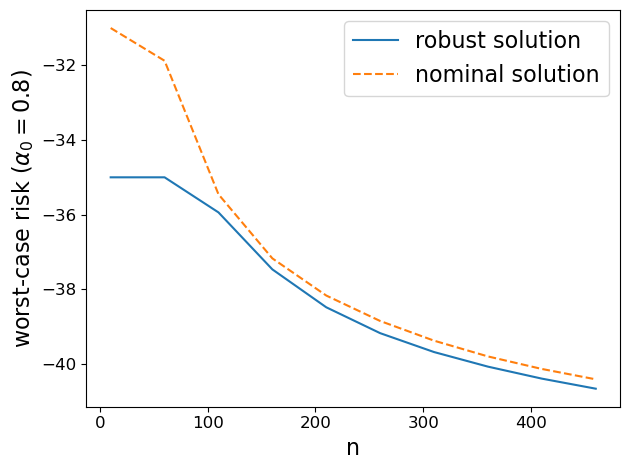

In [27]:
Nsize = np.arange(10,500,50) ### for alpha_0 = 0.9, 0.8
#Nsize = np.arange(10,200,20)  ### for alpha_0 = 0.4,0.3
L = len(Nsize)
wcrisk_rob = np.zeros(L)
wcrisk_nom = np.zeros(L)
for i in range(L):
    r = phi_dot/(2*Nsize[i])*scipy.stats.chi2.ppf(0.95, m-1)    ### determining the radius of the phi-divergence set
    wcrisk_rob[i] = mnews_affine_riskmin(p,d,r,indices,par_mnews,phi_conj,np.array([1/(1-par),0]),np.array([0,1]))[1]
    res_nom = mnews_affine_riskmin(p,d,0,indices,par_mnews,phi_conj,np.array([1/(1-par),0]),np.array([0,1]))[0]
    print(i)
    wcrisk_nom[i] = robustcheck_riskmin(res_nom,d,r,p,par,par_mnews,indices,hf.h_cvar_cut, phi.kb_cut)[0]
plt.plot(Nsize, wcrisk_rob, label = 'robust solution')
plt.plot(Nsize, wcrisk_nom,'--', label = 'nominal solution')
plt.xlabel('n', fontsize = 16)
plt.ylabel(r'worst-case risk ($\alpha_0=0.8$)', fontsize = 16)
plt.xticks(fontsize=12)  # Set font size for x-axis tick labels
plt.yticks(fontsize=12)
plt.legend(fontsize = 16)
plt.tight_layout()
plt.savefig('mnewline08.eps', format = 'eps')